**Topic modeling is a powerful technique in natural language processing to find hidden meaning from the text body. It uses the concept of Latent Dirichlet Allocation (LDA).**


We will build LDA models on various datasets, which will be used in our application,  We'll use the gensim implementation of LDA, though sklearn also comes with one. 

Other libraries being used include NLTK and pyLDAavis

In [1]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

# import libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import re,random,os
import seaborn as sns
from nltk.corpus import stopwords
import string
from pprint import pprint as pprint

# spacy for basic processing, optional, can use nltk as well(lemmatisation etc.)
import spacy

#gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#plotting tools
import pyLDAvis
import pyLDAvis.gensim #dont skip this
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Amazon Product Reviews Dataset 



In [3]:
df=pd.read_csv('../input/amazon-reviews-data/Amazon Reviews.csv')
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1597 non-null   object 
 1   asins                 1597 non-null   object 
 2   brand                 1597 non-null   object 
 3   categories            1597 non-null   object 
 4   colors                774 non-null    object 
 5   dateAdded             1597 non-null   object 
 6   dateUpdated           1597 non-null   object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend  

In [5]:
df[df['asins']=='B01BH83OOM']['keys'][852]

'amazontapalexaenabledportablebluetoothspeaker/b01bh83oom,amazonamazontapportablebluetoothwifispeakerblack/5097300,841667107929,amazonecho/52353110,0841667107929,tapalexaenabledportablebluetoothspeaker/05743627000p,amazon/53004496,amazon/b01bh83oom,amazontapportablebluetoothwifispeakerblack/1001803403'

In [6]:
df[df['asins']=='B01BH83OOM']['name'][854]

'Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker'

In [7]:
# filter for product id = amazon tap
df = df[df['asins']=="B01BH83OOM"]
df.head(3)

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
852,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",IMPORTANT UPDATE (3/8/17): As you read my orig...,"The Echo's Little Sister Is AMAZING!! 3,",NaN,NaN,Deanokat,NaN,8.416670e+11,1.75 lbs
853,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",It was just a few weeks ago that I was bemoani...,Tap Alexa on the go!,NaN,NaN,Heather A,NaN,8.416670e+11,1.75 lbs
854,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",The Amazon Tap is a portable Bluetooth speaker...,Amazon Tap Review - Best Bluetooth Speaker in ...,NaN,NaN,Quentin Moore,NaN,8.416670e+11,1.75 lbs


### Creating Dictionary and Corpus

`Gensim's LDA requires the data in a certain format. It needs the corpus as a dicionary of id-word mapping, where each word has a unique numeric ID. This is for computationally efficiency purposes. Secondly, it needs the corpus as a term-document frequency matrix which contains the frequency of each word in each document.`

`The (3, 7) above represents the fact that the word with id=3 appears 7 times in the second document (review), word id 12 appears twice and so on. The nested list below shows the frequencies of words in the first document.`

### Building the Topic Model

 We'll define 10 topics to start with. The hyperparameter `alpha` affects sparsity of the document-topic
(theta) distributions, whose default value is 1. Similarly, the hyperparameter `eta` can also be specified, which affects the topic-word distribution's sparsity.



Let's now print the topics found in the dataset.

Let's now evaluate the model using coherence score.

Now lets visualise the topics. The `pyLDAvis` library comes with excellent interactive visualisation capabilities.

## Hyperparameter Tuning - Number of Topics and Alpha

Let's now tune the two main hyperparameters - number of topics and alpha. The strategy typically used is to tune these parameters such that the coherence score is maximised.

In [19]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range,alpha_range):
    coherence_values=[]
    model_list=[]
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, alpha=alpha,num_topics=num_topics,\
                                                      per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel=CoherenceModel(model=lda_model,texts=texts,dictionary=dictionary,coherence='c_v')
            coherence_values.append((alpha,num_topics,coherencemodel.get_coherence()))
    return model_list,coherence_values

In [20]:
# build models accross a range of num_topics and alpha
num_topics_range= [2,6,10,15,20]
alpha_range=[0.01,0.1,1]
model_list, coherence_values= compute_coherence_values(dictionary=id2word,corpus=corpus,texts=data_lemmatized,\
                                                       num_topics_range=num_topics_range,alpha_range=alpha_range)

In [21]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.419622
1,0.01,6,0.392868
2,0.01,10,0.420732
3,0.01,15,0.410385
4,0.01,20,0.424124
5,0.10,2,0.429085
6,0.10,6,0.434674
7,0.10,10,0.432161
8,0.10,15,0.392212
9,0.10,20,0.393432


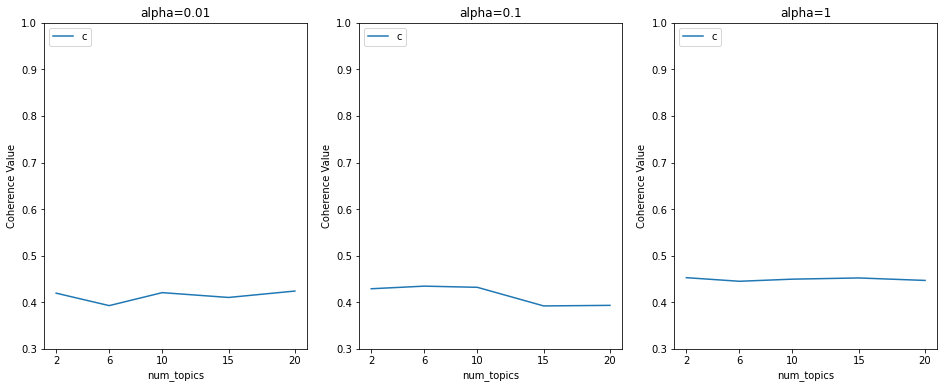

In [22]:
# plot
def plot_coherence(coherence_df,alpha_range,num_topics_range):
    plt.figure(figsize=(16,6))
    
    for i,val in enumerate(alpha_range):
        #subolot 1/3/i
        plt.subplot(1,3,i+1)
        alpha_subset=coherence_df[coherence_df['alpha']==val]
        plt.plot(alpha_subset['num_topics'],alpha_subset['coherence_value'])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title('alpha={0}'.format(val))
        plt.ylim([0.30,1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)
plot_coherence(coherence_df,alpha_range,num_topics_range)

### BBC News Dataset

In [8]:
# tokenize using gensims simple_preprocess
def sent_to_words(sentences, deacc=True):  # deacc=True removes punctuations
    for sentence in sentences:
        yield(simple_preprocess(str(sentence)))

# conver to list
data=df['reviews.text'].values.tolist()
data_words=list(sent_to_words(data))

#sample
print(data_words[3])

['look', 'at', 'this', 'product', 'as', 'portable', 'speaker', 'first', 'and', 'an', 'echo', 'replacement', 'second', 'the', 'big', 'reason', 'to', 'buy', 'this', 'over', 'standard', 'bluetooth', 'speakers', 'is', 'this', 'has', 'wifi', 'streaming', 'enabled', 'when', 'you', 'are', 'at', 'home', 'you', 'can', 'stream', 'music', 'with', 'ease', 'to', 'it', 'voice', 'recognition', 'is', 'top', 'notch', 'and', 'it', 'really', 'shines', 'when', 'using', 'it', 'with', 'other', 'smart', 'home', 'accessories', 'the', 'only', 'problem', 'is', 'having', 'to', 'tap', 'the', 'microphone', 'button', 'for', 'it', 'to', 'listen', 'to', 'your', 'voice', 'if', 'you', 'want', 'bigger', 'sound', 'and', 'always', 'listening', 'features', 'spend', 'the', 'extra', 'money', 'on', 'the', 'amazon', 'echo']


`The code below creates a list of stop words. The 'string' module in python comes with a list of punctuation characters, which we'll append to the builtin stopwords of NLTK.`

In [9]:
# create a list of stop words
# string.punctuation (from the 'string' module) contains a list of punctuations
from nltk.corpus import stopwords
stop_words= stopwords.words('english') + list(string.punctuation)

In [10]:
# functions for removing stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts,allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """https://spacy.io/api/annotation"""
    texts_out=[]
    for sent in texts:
        doc=nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

**Important Note:** All models are not automatically downloaded with spacy, so you will need to do a ```python -m spacy download en``` to use its preprocessing methods.

In [11]:

# call functions

# remove stop words
data_words_npstops= remove_stopwords(data_words)

# initialize spacy 'en' model use only tagger since we don;t need parsing or NER
# python3 -m spacey download en
# spacy.cli.download("en")
nlp=spacy.load('en',disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized=lemmatization(data_words_npstops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[3])

['look', 'product', 'portable', 'echo', 'replacement', 'second', 'big', 'reason', 'buy', 'standard', 'bluetooth', 'speaker', 'wifi', 'streaming', 'enable', 'home', 'stream', 'music', 'ease', 'voice', 'recognition', 'top', 'notch', 'really', 'shine', 'use', 'smart', 'home', 'accessory', 'problem', 'tap', 'listen', 'voice', 'want', 'big', 'sound', 'always', 'listen', 'feature', 'spend', 'extra', 'money']


In [12]:
# compare the nostop, lemmatised version with the original one
# note that speakers is lemmatised to speaker; 
print(' '.join(data_words[3]), '\n')
print(' '.join(data_lemmatized[3]))

look at this product as portable speaker first and an echo replacement second the big reason to buy this over standard bluetooth speakers is this has wifi streaming enabled when you are at home you can stream music with ease to it voice recognition is top notch and it really shines when using it with other smart home accessories the only problem is having to tap the microphone button for it to listen to your voice if you want bigger sound and always listening features spend the extra money on the amazon echo 

look product portable echo replacement second big reason buy standard bluetooth speaker wifi streaming enable home stream music ease voice recognition top notch really shine use smart home accessory problem tap listen voice want big sound always listen feature spend extra money


### Preprocessing

1. Tokenize each review (using gensim)
2. Remove stop words (including punctuations)
3. Lemmatize (using spacy)


In [13]:
# create dictionary and corpus
# create dictionary
id2word=corpora.Dictionary(data_lemmatized)

#create corpus
corpus=[id2word.doc2bow(text) for text in data_lemmatized]

# sample
print(corpus[2])

[(9, 1), (12, 2), (13, 3), (16, 1), (17, 2), (21, 4), (29, 1), (32, 1), (47, 1), (52, 1), (56, 5), (65, 1), (77, 1), (80, 3), (83, 1), (85, 2), (90, 1), (91, 1), (92, 2), (94, 2), (95, 1), (106, 2), (110, 1), (114, 1), (118, 1), (127, 2), (130, 1), (133, 1), (139, 1), (140, 1), (141, 2), (142, 1), (143, 1), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 2), (154, 1), (155, 2), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1), (163, 1), (164, 1), (165, 2), (166, 1), (167, 3), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 1), (179, 1), (180, 1), (181, 2), (182, 1), (183, 2), (184, 1), (185, 5), (186, 1), (187, 3), (188, 2), (189, 1), (190, 3), (191, 1), (192, 1), (193, 1), (194, 1), (195, 6), (196, 1), (197, 1), (198, 1), (199, 2), (200, 1), (201, 2), (202, 1), (203, 1), (204, 1), (205, 1), (206, 1), (207, 2), (208, 1), (209, 2), (210, 1)]


In [37]:
# Reading the BBC news dataset
data_folder="../input/bbc-news-summary/BBC News Summary/News Articles"
folders=["business","entertainment","politics","sport","tech"]
x=[]
y=[]


for i in folders:
    files=os.listdir(data_folder+'/'+i)
    for text_file in files:
        file_path=data_folder + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        x.append(data)
        y.append(i)
        
data={'news':x,'type':y}
df = pd.DataFrame(data)
df.to_csv('bbc_data.csv', index=False)        

In [14]:
# human-readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('admit', 1),
  ('allow', 1),
  ('announce', 1),
  ('answer', 1),
  ('anyway', 1),
  ('app', 1),
  ('appealing', 1),
  ('associate', 1),
  ('avid', 1),
  ('battery', 3),
  ('buy', 1),
  ('choose', 2),
  ('command', 1),
  ('control', 1),
  ('convenience', 1),
  ('cook', 1),
  ('could', 2),
  ('day', 1),
  ('decide', 2),
  ('demand', 1),
  ('development', 1),
  ('device', 3),
  ('dot', 1),
  ('drain', 1),
  ('early', 2),
  ('easily', 2),
  ('echo', 5),
  ('echos', 1),
  ('enable', 1),
  ('especially', 1),
  ('fabulous', 1),
  ('financial', 1),
  ('first', 1),
  ('free', 6),
  ('get', 1),
  ('give', 1),
  ('go', 1),
  ('hand', 6),
  ('high', 1),
  ('hope', 1),
  ('important', 1),
  ('introduce', 1),
  ('keep', 1),
  ('kitchen', 1),
  ('lack', 1),
  ('listener', 1),
  ('little', 2),
  ('lot', 1),
  ('love', 1),
  ('major', 1),
  ('make', 1),
  ('maximum', 1),
  ('microphone', 1),
  ('mind', 1),
  ('minimal', 1),
  ('mode', 2),
  ('music', 2),
  ('operation', 1),
  ('option', 2),
  ('orig

In [38]:
df.head()

,news,type
0,b'US consumer confidence up\n\nConsumers\' con...,business
1,b'The \'ticking budget\' facing the US\n\nThe ...,business
2,"b""Mitsubishi in Peugeot link talks\n\nTrouble-...",business
3,b'BMW reveals new models pipeline\n\nBMW is pr...,business
4,b'World leaders gather to face uncertainty\n\n...,business


In [39]:
df.type.astype('category').value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: type, dtype: int64

In [15]:
# Build LDA model
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=10,random_state=100,\
                                          update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)

In [40]:
# filter business articles
df = df[df['type']=='business']
df.shape

(510, 2)

In [16]:
# print the 10 topics
lda_model.print_topics()

[(0,
  '0.056*"great" + 0.052*"sound" + 0.047*"use" + 0.035*"good" + 0.030*"love" + 0.030*"speaker" + 0.028*"music" + 0.027*"work" + 0.027*"alexa" + 0.024*"portable"'),
 (1,
  '0.101*"would" + 0.049*"recommend" + 0.049*"purchase" + 0.031*"think" + 0.027*"may" + 0.026*"item" + 0.026*"much" + 0.026*"news" + 0.026*"want" + 0.025*"still"'),
 (2,
  '0.051*"tap" + 0.049*"echo" + 0.027*"button" + 0.027*"voice" + 0.027*"add" + 0.022*"activate" + 0.021*"push" + 0.019*"command" + 0.017*"anywhere" + 0.017*"well"'),
 (3,
  '0.049*"size" + 0.040*"charge" + 0.032*"hold" + 0.031*"order" + 0.030*"actually" + 0.027*"want" + 0.024*"stream" + 0.022*"phone" + 0.016*"wireless" + 0.016*"case"'),
 (4,
  '0.066*"get" + 0.038*"tap" + 0.034*"play" + 0.029*"music" + 0.022*"little" + 0.020*"thing" + 0.018*"say" + 0.014*"try" + 0.014*"find" + 0.013*"could"'),
 (5,
  '0.053*"need" + 0.049*"buy" + 0.046*"love" + 0.031*"gift" + 0.030*"wish" + 0.030*"go" + 0.027*"press" + 0.021*"small" + 0.017*"old" + 0.016*"would"'),

In [41]:
# convert to list
data=df['news'].values.tolist()
data_words=list(sent_to_words(data))

# remove stop words
data_words_nostops= remove_stopwords(data_words)

#lemmatize
nlp = spacy.load('en', disable=['parser','ner'])
data_lemmatized = lemmatization(data_words_nostops,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



In [17]:
# coherence score
coherence_model_lda=CoherenceModel(model=lda_model,texts=data_lemmatized,dictionary=id2word,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score:',coherence_lda)


Coherence Score: 0.43708922544068596


## Creating Dictionary and Corpus

`Gensim's LDA requires the data in a certain format. Firstly, it needs the corpus as a dicionary of id-word mapping, where each word has a unique numeric ID. This is for computationally efficiency purposes. Secondly, it needs the corpus as a term-document frequency matrix which contains the frequency of each word in each document.`

In [18]:
# visulaise the topics
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.350326  0.035394       1        1  45.279865
4      0.170648  0.081121       2        1  15.213650
2      0.090733 -0.221680       3        1  11.410499
1     -0.119493  0.171135       4        1   6.421736
5     -0.029389  0.150002       5        1   5.848545
3     -0.112541 -0.047986       6        1   4.878042
9     -0.044533 -0.064423       7        1   4.386019
6     -0.105507 -0.042206       8        1   3.011567
8     -0.106624 -0.020198       9        1   2.134573
7     -0.093620 -0.041158      10        1   1.415503, topic_info=            Term        Freq       Total Category  logprob  loglift
48          love  142.000000  142.000000  Default  30.0000  30.0000
391         easy   43.000000   43.000000  Default  29.0000  29.0000
34           get   84.000000   84.000000  Default  28.0000  28.0000
97         would   62.000000   62.000000  Default  27.0000  27.0000
91           use  185.000000  185.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1023   unlocking    0.493586    1.213876  Topic10  -5.4689   3.3578
1022    reliable    0.493586    1.213876  Topic10  -5.4689   3.3578
1029  frequently    0.492749    1.213292  Topic10  -5.4706   3.3566
1027  competitor    0.492749    1.213292  Topic10  -5.4706   3.3566
12       command    0.836822   24.777555  Topic10  -4.9410   0.8696

[432 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
277       1  0.995465        able
417       5  0.921199  absolutely
229       2  0.971526      access
1025      7  0.799918    accurate
141       3  0.976251    activate
...     ...       ...         ...
97        4  0.870731       would
97        5  0.128997       would
139       5  0.634179        year
139       7  0.253672        year
670       9  0.879729         yet

[475 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 6, 4, 10, 7, 9, 8])

In [ ]:
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

#create corpus
texts = data_lemmatized

#term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

## Building the Topic Model


In [42]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## Computing coherence score


In [43]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4499446504324448


In [44]:
# print keywords
pprint(lda_model.print_topics())


[(0,
  '0.022*"gorge" + 0.019*"dam" + 0.016*"environmental" + 0.008*"power" + '
  '0.007*"mandatory" + 0.006*"sand" + 0.005*"draw" + 0.000*"sepa" + '
  '0.000*"downstream" + 0.000*"chronic"'),
 (1,
  '0.030*"develop" + 0.023*"unfair" + 0.020*"nationwide" + 0.019*"customer" + '
  '0.019*"decision" + 0.017*"position" + 0.016*"insurance" + 0.016*"private" + '
  '0.015*"find" + 0.014*"evidence"'),
 (2,
  '0.023*"company" + 0.020*"airline" + 0.020*"case" + 0.018*"oil" + '
  '0.017*"court" + 0.015*"russian" + 0.014*"claim" + 0.014*"unit" + '
  '0.013*"state" + 0.013*"sale"'),
 (3,
  '0.088*"card" + 0.071*"volume" + 0.032*"equip" + 0.026*"credit" + '
  '0.021*"creditor" + 0.014*"consortium" + 0.012*"buying" + 0.012*"rescue" + '
  '0.011*"train" + 0.011*"bubble"'),
 (4,
  '0.013*"impetus" + 0.012*"minute" + 0.008*"tube" + 0.008*"reap" + '
  '0.007*"reading" + 0.005*"wharf" + 0.003*"crossrail" + 0.001*"proximity" + '
  '0.001*"provided" + 0.001*"treasury"'),
 (5,
  '0.000*"appear" + 0.000*"wron

In [45]:
doc_lda = lda_model[corpus]


## Visualize the topics


In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.244425 -0.046253       1        1  28.651353
18     0.249304  0.049701       2        1  11.569925
10     0.288971 -0.197095       3        1  10.862863
11     0.204021  0.149917       4        1  10.518417
12     0.244651 -0.216842       5        1   9.264144
2      0.189019  0.186206       6        1   8.826582
7      0.136375 -0.055649       7        1   5.764434
15     0.059587  0.143193       8        1   4.470297
8     -0.016003  0.046070       9        1   3.064543
1     -0.011154  0.153504      10        1   2.875692
16    -0.087373  0.109205      11        1   1.565822
14    -0.146532  0.000770      12        1   0.633784
6     -0.149859 -0.062019      13        1   0.504358
3     -0.171021 -0.042845      14        1   0.503218
9     -0.176877 -0.040837      15        1   0.271552
17    -0.177773 -0.039553      16        1   0.265884
13    -0.175532 -0.041670      17        1   0.249283
0     -0.169522 -0.032406      18        1   0.069654
4     -0.168936 -0.033116      19        1   0.059859
5     -0.165772 -0.030280      20        1   0.008336, topic_info=             Term        Freq       Total Category  logprob  loglift
641         price  491.000000  491.000000  Default  30.0000  30.0000
833           oil  269.000000  269.000000  Default  29.0000  29.0000
364          firm  465.000000  465.000000  Default  28.0000  28.0000
57           rise  483.000000  483.000000  Default  27.0000  27.0000
487       country  366.000000  366.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
2070      partner    0.000925   14.767721  Topic20  -8.7389  -0.2856
2058        sweet    0.000925    1.957764  Topic20  -8.7389   1.7350
2049     gasoline    0.000925    2.766895  Topic20  -8.7389   1.3891
2050  instability    0.000925    2.583935  Topic20  -8.7389   1.4575
2051   mechanical    0.000925    0.763147  Topic20  -8.7389   2.6771

[1036 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2077      2  0.809550      absorb
1264      8  0.991108      accept
2508     12  0.589412  accomodate
0         1  0.846439      accord
0         3  0.066824      accord
...     ...       ...         ...
73        6  0.054120        year
73        7  0.114660        year
73        8  0.004586        year
73       10  0.000917        year
1723      5  0.992735         yen

[1564 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 19, 11, 12, 13, 3, 8, 16, 9, 2, 17, 15, 7, 4, 10, 18, 14, 1, 5, 6])

## Hyperparameter Tuning - Number of Topics and Alpha



In [47]:
# build models across a range of num_topics and alpha
num_topics_range=[2,6,10,15]
alpha_range=[0.01,0.1,1]
model_list, coherence_values=compute_coherence_values(dictionary=id2word,corpus=corpus,texts=data_lemmatized,\
                                                      num_topics_range=num_topics_range,\
                                                     alpha_range=alpha_range)
coherence_df=pd.DataFrame(coherence_values,columns=['alpha','num_topics','coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.307777
1,0.01,6,0.294715
2,0.01,10,0.300718
3,0.01,15,0.284745
4,0.10,2,0.297096
5,0.10,6,0.307790
6,0.10,10,0.295126
7,0.10,15,0.300221
8,1.00,2,0.295729
9,1.00,6,0.307726


## Coherence plots

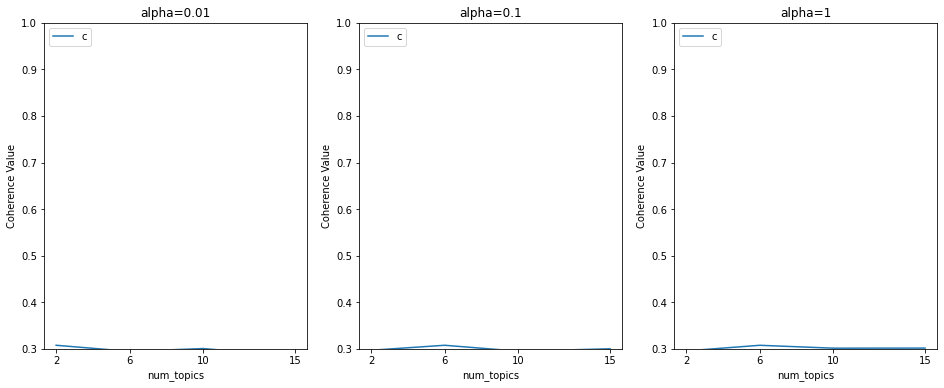

In [48]:
# plot
plot_coherence(coherence_df, alpha_range, num_topics_range)